# Ch 6 - Applied Problems

## Problem 8

In this exercise, we will generate simulated data, and will then use this data to perform forward and backward stepwise selection.

(a) Create a random number generator and use its normal() method to generate a predictor X of length n = 100, as well as a noise vector ε of length n = 100.

(b) Generate a response vector Y of length n = 100 according to the model
Y =β0 +β1X+β2X2 +β3X3 +ε, where β0, β1, β2, and β3 are constants of your choice.

(c) Use forward stepwise selection in order to select a model contain- ing the predictors X, X2, . . . , X10. What is the model obtained according to Cp? Report the coefficients of the model obtained.

(d) Repeat (c), using backwards stepwise selection. How does your answer compare to the results in (c)?

(e) Now fit a lasso model to the simulated data, again using X,X2, . . . , X 10 as predictors. Use cross-validation to select the optimal value of λ. Create plots of the cross-validation error as a function of λ. Report the resulting coefficient estimates, and discuss the results obtained.

(f) Now generate a response vector Y according to the model Y = β0 + β7X7 + ε,
and perform forward stepwise selection and the lasso. Discuss the results obtained.

In [23]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV 
from sklearn.preprocessing import PolynomialFeatures, scale, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from itertools import combinations
from tqdm import tqdm
import statsmodels.formula.api as smf

In [119]:
# (a) 
np.random.seed(5)
x = np.random.randn(100,1)
eps = np.random.randn(100,1)

# (b)
betas = [5, -10, 3, 14]
y = betas[0] + betas[1] * x + betas[2] * (x**2) + betas[3] * (x**3) + eps

(c) Use forward stepwise selection in order to select a model contain- ing the predictors X, X2, . . . , X10. What is the model obtained according to Cp? Report the coefficients of the model obtained.


In [120]:
# (c)
poly = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly.fit_transform(x)

cols = ['x_'+str(i) for i in range(1, 11)] + ['y']
df = pd.DataFrame(np.concatenate((X_poly,y), axis=1), columns=cols)
df.head()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
0,0.441227,0.194682,0.085899,0.037901,0.016723,0.007379,3.255652e-03,1.436483e-03,6.338158e-04,2.796569e-04,3.166778
1,-0.330870,0.109475,-0.036222,0.011985,-0.003965,0.001312,-4.341133e-04,1.436351e-04,-4.752458e-05,1.572447e-05,8.300783
2,2.430771,5.908649,14.362573,34.912128,84.863394,206.283494,5.014280e+02,1.218857e+03,2.962762e+03,7.201796e+03,197.740511
3,-0.252092,0.063550,-0.016021,0.004039,-0.001018,0.000257,-6.470160e-05,1.631076e-05,-4.111815e-06,1.036556e-06,8.117581
4,0.109610,0.012014,0.001317,0.000144,0.000016,0.000002,1.900846e-07,2.083514e-08,2.283736e-09,2.503200e-10,4.456710


- Note, when doing forward/backward selection, we look for the best model for each k where k is the number of predictors based on rss. Then we look at the best kth model based on Cp, information criteria, or cross validation.
- First, we'll select the best models for each number of predictors k below

In [121]:
best_models = [] # best overall model
num_features = []
best_feature_subset = []
max_features = 10

# Loop over a number of features from 1 to all of them
for i in range(1, max_features):
    smallest_rss = np.inf # use to select best mdoel for each no. of k predictors
    best_kth_model = [] # select best model based on rss
    # Get permutations of the the features
    feature_subsets = combinations([col for col in df.columns if col != 'y'], i)

    # Loop over these subsets and fit models, getting results each time
    for subset in feature_subsets:
        model_string = f"y ~ {' + '.join(subset)}" # Create model string
        result = smf.ols(formula=model_string, data=df).fit() # fit and get results
        rss = (result.resid**2).sum()
        # Try to get best rss
        if rss < smallest_rss:
            smallest_rss = rss
            best_kth_subset = list(subset)
            best_kth_model = result
    best_models.append(best_kth_model)
    best_feature_subset.append(best_kth_subset)

# Create dataframe of feature subsets and models for each subset
forward_selection_df = pd.DataFrame({'subset': best_feature_subset, 'model': best_models})
forward_selection_df.head()

,subset,model
0,[x_3],<statsmodels.regression.linear_model.Regressio...
1,"[x_5, x_7]",<statsmodels.regression.linear_model.Regressio...
2,"[x_1, x_2, x_3]",<statsmodels.regression.linear_model.Regressio...
3,"[x_1, x_2, x_3, x_5]",<statsmodels.regression.linear_model.Regressio...
4,"[x_1, x_2, x_3, x_7, x_10]",<statsmodels.regression.linear_model.Regressio...


- For least squares regression, AIC is approximately Mallow's CP. Stats models already gets AIC and BIC for each model. So we can just calculate that and then identify the model with the smallest value.

In [56]:
forward_selection_df['AIC'] = forward_selection_df['model'].apply(lambda m: m.aic)
forward_selection_df['BIC'] = forward_selection_df['model'].apply(lambda m: m.bic)
forward_selection_df['num_features'] = forward_selection_df['subset'].apply(lambda m: len(m))
forward_selection_df.head()

,subset,model,AIC,BIC,num_features
0,[x_3],<statsmodels.regression.linear_model.Regressio...,651.953613,657.163953,1
1,"[x_5, x_7]",<statsmodels.regression.linear_model.Regressio...,555.310052,563.125563,2
2,"[x_1, x_2, x_3]",<statsmodels.regression.linear_model.Regressio...,296.188339,306.609019,3
3,"[x_1, x_2, x_3, x_5]",<statsmodels.regression.linear_model.Regressio...,292.619087,305.644938,4
4,"[x_1, x_2, x_3, x_7, x_10]",<statsmodels.regression.linear_model.Regressio...,287.070854,302.701875,5


In [55]:
best_by_aic = forward_selection_df.loc[forward_selection_df['AIC'].idxmin()]
best_by_bic = forward_selection_df.loc[forward_selection_df['BIC'].idxmin()]

print("Best AIC model uses:", best_by_aic['subset'])
print(best_by_aic['model'].summary())


Best AIC model uses: ['x_1', 'x_2', 'x_3', 'x_5', 'x_6', 'x_7', 'x_9']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.703e+04
Date:                Tue, 24 Jun 2025   Prob (F-statistic):          1.82e-149
Time:                        09:52:27   Log-Likelihood:                -134.65
No. Observations:                 100   AIC:                             285.3
Df Residuals:                      92   BIC:                             306.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

- Thus by forward subset selection, we find the best model has 7 features x1, x2, x3, x5, x6, x7, and x9. But this differed by random seed. Additionally, we see the following graph of AIC's

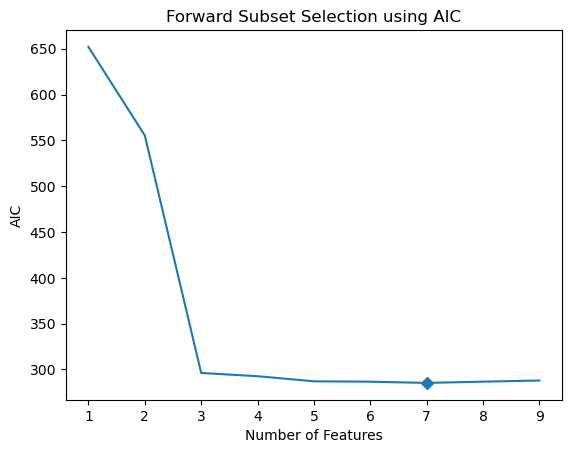

In [62]:
xs = forward_selection_df['num_features']
ys = forward_selection_df['AIC']
plt.plot(xs,ys, markevery=[np.argmin(ys)], marker='D')
plt.title("Forward Subset Selection using AIC")
plt.xlabel("Number of Features")
plt.ylabel("AIC")
plt.show()

In [ ]:
# (d) Backward selection
"""
best_models = [] # best overall model
num_features = []
best_feature_subset = []
min_features = 11
feature_list = df.drop(columns=['y']).columns

# Loop over smaller subsets of features starting with all
while len(feature_list)>=min_features:
    smallest_rss = np.inf # use to select best mdoel for each no. of k predictors
    best_kth_model = [] # select best model based on rss
    
    # Get next smallest subset of features
    feature_subsets = combinations([col for col in df.columns if col != 'y'], i)
    for feature in feature_list:
        new_feature_subset = [col for col in feature_list if col != feature]
        model_string = f"y ~ {' + '.join(new_feature_subset)}" # Create model string
        result = smf.ols(formula=model_string, data=df).fit() # fit and get results
        rss = (result.resid**2).sum()
        # Try to get best rss
        if rss < smallest_rss:
            smallest_rss = rss
            best_kth_subset = list(subset)
            best_kth_model = result
    best_models.append(best_kth_model)
    best_feature_subset.append(best_kth_subset)

# Create dataframe of feature subsets and models for each subset
forward_selection_df = pd.DataFrame({'subset': best_feature_subset, 'model': best_models})
forward_selection_df.head()
"""

(e) Now fit a lasso model to the simulated data, again using X,X2, . . . , X 10 as predictors. Use cross-validation to select the optimal value of λ. Create plots of the cross-validation error as a function of λ. Report the resulting coefficient estimates, and discuss the results obtained.


In [129]:
from sklearn.pipeline import Pipeline
# Set up data
X = df.drop(columns=['y'])
y = df['y']

# Set up pipeline for standardizing and running lasso fit
#lambdas = np.logspace(-4,1,100)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso_cv', LassoCV(n_alphas=500, cv=5, random_state=5, max_iter=100000)),
])

results = pipeline.fit(X,y)

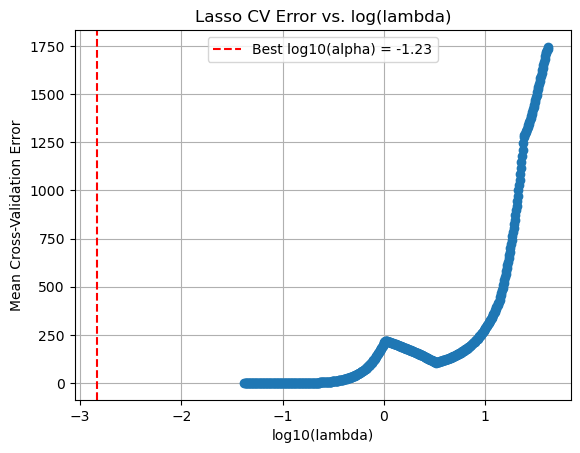

In [130]:
mse_path = results['lasso_cv'].mse_path_ # Get the MSE for each k-fold for each alpha
lambdas = results['lasso_cv'].alphas_ # .alpha returns best alpha, alaphs returns all alphas used
best_lambda = results['lasso_cv'].alpha_
mse_means = np.mean(mse_path, axis=1) # Need to get mean of all 5 folds for each alpha

plt.plot(np.log10(lambdas), mse_means, marker='o') # Make log scale plot
plt.axvline(np.log(best_lambda), color='red', linestyle='--', label=f'Best log10(alpha) = {np.log10(best_lambda):.2f}')
plt.xlabel('log10(lambda)')
plt.ylabel('Mean Cross-Validation Error')
plt.title('Lasso CV Error vs. log(lambda)')
plt.legend()
plt.grid(True)
plt.show()

In [87]:
df

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
0,0.441227,0.194682,0.085899,0.037901,0.016723,0.007379,3.255652e-03,1.436483e-03,6.338158e-04,2.796569e-04,3.166778
1,-0.330870,0.109475,-0.036222,0.011985,-0.003965,0.001312,-4.341133e-04,1.436351e-04,-4.752458e-05,1.572447e-05,8.300783
2,2.430771,5.908649,14.362573,34.912128,84.863394,206.283494,5.014280e+02,1.218857e+03,2.962762e+03,7.201796e+03,197.740511
3,-0.252092,0.063550,-0.016021,0.004039,-0.001018,0.000257,-6.470160e-05,1.631076e-05,-4.111815e-06,1.036556e-06,8.117581
4,0.109610,0.012014,0.001317,0.000144,0.000016,0.000002,1.900846e-07,2.083514e-08,2.283736e-09,2.503200e-10,4.456710
...,...,...,...,...,...,...,...,...,...,...,...
95,0.788238,0.621319,0.489747,0.386037,0.304289,0.239852,1.890607e-01,1.490249e-01,1.174670e-01,9.259198e-02,6.744929
96,-0.445430,0.198408,-0.088377,0.039366,-0.017535,0.007810,-3.479014e-03,1.549657e-03,-6.902638e-04,3.074642e-04,8.836459
97,-0.482120,0.232440,-0.112064,0.054028,-0.026048,0.012558,-6.054624e-03,2.919057e-03,-1.407336e-03,6.785052e-04,8.709644
98,0.493558,0.243599,0.120230,0.059341,0.029288,0.014455,7.134529e-03,3.521301e-03,1.737965e-03,8.577860e-04,3.388555


In [128]:
# Now get the coefficients and put in nice dataframe
best_coefs = results['lasso_cv'].coef_
lasso_df = pd.DataFrame({'feature': X.columns, 'coef': best_coefs})
lasso_df

,feature,coef
0,x_1,-8.833296
1,x_2,3.883155
2,x_3,48.522630
3,x_4,0.000000
4,x_5,0.000000
5,x_6,-0.000000
6,x_7,0.000000
7,x_8,-0.000000
8,x_9,0.000000
9,x_10,-0.000000


- Thus lasso with 5 fold CV got us that x1, x2, and x3 survived the longest with x3 being most dominant. The actual model had only x, x^2, and x^3 in it...so this makes sense that we'd only get those coefficients. Looks like Lasso worked much better than forward subset selection.

(f) Now generate a response vector Y according to the model Y = β0 + β7X7 + ε,
and perform forward stepwise selection and the lasso. Discuss the results obtained.

In [131]:
# Make new data with new response
np.random.seed(5)
x = np.random.randn(100,1)
eps = np.random.randn(100,1)
y2 = -4 + 7.25 * (x**7) + eps

poly = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly.fit_transform(x)

cols = ['x_'+str(i) for i in range(1, 11)] + ['y2']
df = pd.DataFrame(np.concatenate((X_poly,y2), axis=1), columns=cols)
df.head()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y2
0,0.441227,0.194682,0.085899,0.037901,0.016723,0.007379,3.255652e-03,1.436483e-03,6.338158e-04,2.796569e-04,-3.183974
1,-0.330870,0.109475,-0.036222,0.011985,-0.003965,0.001312,-4.341133e-04,1.436351e-04,-4.752458e-05,1.572447e-05,-3.832383
2,2.430771,5.908649,14.362573,34.912128,84.863394,206.283494,5.014280e+02,1.218857e+03,2.962762e+03,7.201796e+03,3629.599069
3,-0.252092,0.063550,-0.016021,0.004039,-0.001018,0.000257,-6.470160e-05,1.631076e-05,-4.111815e-06,1.036556e-06,-3.370173
4,0.109610,0.012014,0.001317,0.000144,0.000016,0.000002,1.900846e-07,2.083514e-08,2.283736e-09,2.503200e-10,-3.501669


Best AIC model uses: ['x_3', 'x_5', 'x_6', 'x_7', 'x_9']
                            OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.197e+07
Date:                Tue, 24 Jun 2025   Prob (F-statistic):          3.65e-291
Time:                        11:21:51   Log-Likelihood:                -135.31
No. Observations:                 100   AIC:                             282.6
Df Residuals:                      94   BIC:                             298.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

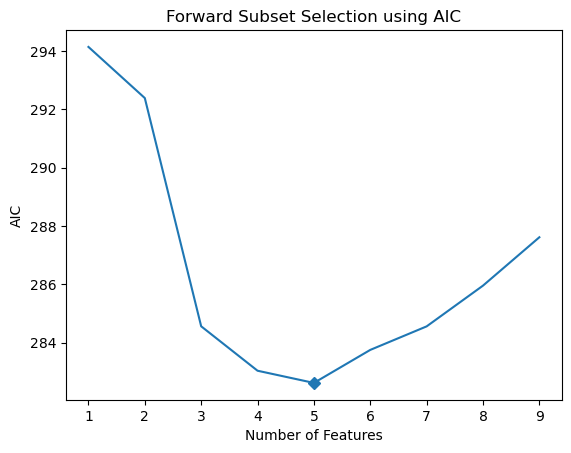

In [108]:
# Do forward subset selection again
best_models = [] # best overall model
num_features = []
best_feature_subset = []
max_features = 10

# Loop over a number of features from 1 to all of them
for i in range(1, max_features):
    smallest_rss = np.inf # use to select best mdoel for each no. of k predictors
    best_kth_model = [] # select best model based on rss
    # Get permutations of the the features
    feature_subsets = combinations([col for col in df.columns if col != 'y2'], i)

    # Loop over these subsets and fit models, getting results each time
    for subset in feature_subsets:
        model_string = f"y2 ~ {' + '.join(subset)}" # Create model string
        result = smf.ols(formula=model_string, data=df).fit() # fit and get results
        rss = (result.resid**2).sum()
        # Try to get best rss
        if rss < smallest_rss:
            smallest_rss = rss
            best_kth_subset = list(subset)
            best_kth_model = result
    best_models.append(best_kth_model)
    best_feature_subset.append(best_kth_subset)

# Create dataframe of feature subsets and models for each subset
forward_selection_df = pd.DataFrame({'subset': best_feature_subset, 'model': best_models})

forward_selection_df['AIC'] = forward_selection_df['model'].apply(lambda m: m.aic)
forward_selection_df['BIC'] = forward_selection_df['model'].apply(lambda m: m.bic)
forward_selection_df['num_features'] = forward_selection_df['subset'].apply(lambda m: len(m))

best_by_aic = forward_selection_df.loc[forward_selection_df['AIC'].idxmin()]
best_by_bic = forward_selection_df.loc[forward_selection_df['BIC'].idxmin()]

print("Best AIC model uses:", best_by_aic['subset'])
print(best_by_aic['model'].summary())

xs = forward_selection_df['num_features']
ys = forward_selection_df['AIC']
plt.plot(xs,ys, markevery=[np.argmin(ys)], marker='D')
plt.title("Forward Subset Selection using AIC")
plt.xlabel("Number of Features")
plt.ylabel("AIC")
plt.show()

- So even though the real model oly has x7 in it, forward subset gives us 5 features, although x7 is the dominant coefficient.

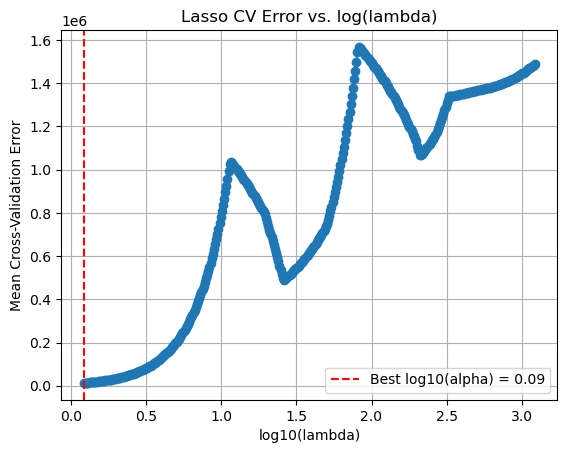

In [132]:
# Now do lasso again
X = df.drop(columns=['y2'])
y2 = df['y2']

# Set up pipeline for standardizing and running lasso fit
lambdas = np.logspace(-4,1,100)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso_cv', LassoCV(n_alphas=400, cv=5, random_state=5, max_iter=100000)),
])

results = pipeline.fit(X,y2)

mse_path = results.named_steps['lasso_cv'].mse_path_ # Get the MSE for each k-fold for each alpha
lambdas = results.named_steps['lasso_cv'].alphas_ # .alpha returns best alpha, alaphs returns all alphas used
best_lambda = results.named_steps['lasso_cv'].alpha_
mse_means = np.mean(mse_path, axis=1) # Need to get mean of all 5 folds for each alpha

plt.plot(np.log10(lambdas), mse_means, marker='o') # Make log scale plot
plt.axvline(np.log10(best_lambda), color='red', linestyle='--', label=f'Best log10(alpha) = {np.log10(best_lambda):.2f}')
plt.xlabel('log10(lambda)')
plt.ylabel('Mean Cross-Validation Error')
plt.title('Lasso CV Error vs. log(lambda)')
plt.legend()
plt.grid(True)
plt.show()

In [133]:
best_coefs = results['lasso_cv'].coef_
lasso_df = pd.DataFrame({'feature': X.columns, 'coef': best_coefs})
lasso_df

,feature,coef
0,x_1,-0.000000
1,x_2,0.000000
2,x_3,0.000000
3,x_4,0.000000
4,x_5,59.222959
5,x_6,0.000000
6,x_7,1069.219682
7,x_8,-0.000000
8,x_9,93.073638
9,x_10,-0.000000


- Lasso gives us much better results with only 2 non-zero coefficients that we know are actually zero. And x7 is by far the dominant feature!.

## Problem 9
In this exercise, we will predict the number of applications received using the other variables in the College data set.

(a) Split the data set into a training set and a test set.

(b) Fit a linear model using least squares on the training set, and report the test error obtained.

(c) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

(d) Fit a lasso model on the training set, with λ chosen by cross- validation. Report the test error obtained, along with the num- ber of non-zero coefficient estimates.

(e) Fit a PCR model on the training set, with M chosen by cross- validation. Report the test error obtained, along with the value of M selected by cross-validation.

(f) Fit a PLS model on the training set, with M chosen by cross- validation. Report the test error obtained, along with the value of M selected by cross-validation.

(g) Comment on the results obtained. How accurately can we pre- dict the number of college applications received? Is there much difference among the test errors resulting from these five approaches?


In [177]:
college = pd.read_csv('./data/College.csv', index_col=0)
college.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [179]:
pd.get_dummies(college['Private'])

,No,Yes
Abilene Christian University,False,True
Adelphi University,False,True
Adrian College,False,True
Agnes Scott College,False,True
Alaska Pacific University,False,True
...,...,...
Worcester State College,True,False
Xavier University,False,True
Xavier University of Louisiana,False,True
Yale University,False,True


In [180]:
# Light preprocessing
college['Private'] = pd.get_dummies(college['Private'])['Yes']
college = college.dropna()

In [151]:
college.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,1.0,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,1.0,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,1.0,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,1.0,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,1.0,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


MSE for Lin. Reg. = 1425055.5873112115


Text(0.5, 1.0, 'Residuals of OLS Model')

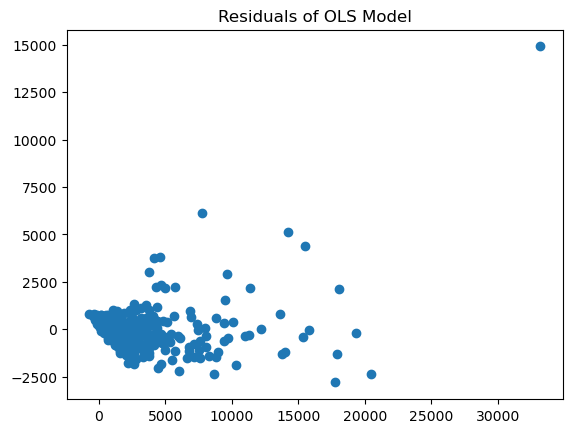

In [187]:
# (a) split data
X_train, X_test, y_train, y_test = train_test_split(college.drop(columns=['Apps'], axis=1), college['Apps'], test_size = 0.5, random_state=1)

# (b) fit ols
ols = LinearRegression()
ols.fit(X_train, y_train)
y_pred = ols.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"MSE for Lin. Reg. = {mse}")

plt.scatter(y_pred, y_test - y_pred)
plt.title("Residuals of OLS Model")

(c) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

/opt/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Best lambda/alpha value = 4.198707084443915


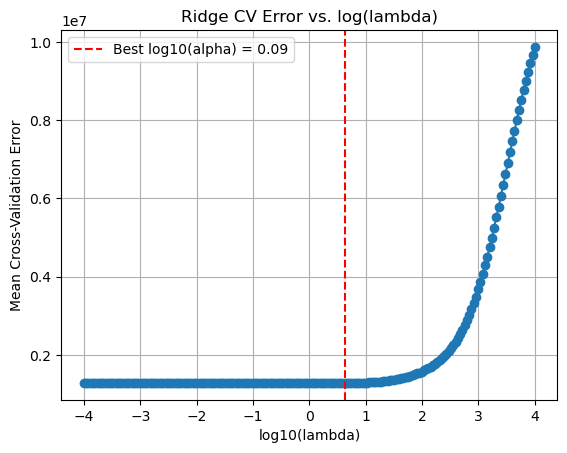

In [191]:
# (c) Run ridge regression and choose optimal lambda with cross validation
from sklearn.linear_model import RidgeCV
alphas = np.logspace(-4,4,200)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge_cv', RidgeCV(alphas=alphas, store_cv_values=True)),
])
pipeline.fit(X_train, y_train)

cvs = pipeline.named_steps['ridge_cv'].cv_results_ # Yields object of shape (n_entries, n_alphas)
mses = np.mean(cvs, axis=0) # Find mean vertically so you get MSE for each fold, resulting shape (n_alphas,)
best_alpha = pipeline.named_steps['ridge_cv'].alpha_

print(f"Best lambda/alpha value = {best_alpha}")

plt.plot(np.log10(alphas), mses, marker='o') # Make log scale plot
plt.axvline(np.log10(best_alpha), color='red', linestyle='--', label=f'Best log10(alpha) = {np.log10(best_lambda):.2f}')
plt.xlabel('log10(lambda)')
plt.ylabel('Mean Cross-Validation Error')
plt.title('Ridge CV Error vs. log(lambda)')
plt.legend()
plt.grid(True)
plt.show()

In [193]:
coef_df = pd.DataFrame({'feature': X_test.columns, 'coefs': pipeline.named_steps['ridge_cv'].coef_})
coef_df

,feature,coefs
0,Private,-203.003819
1,Accept,2372.058827
2,Enroll,539.143066
3,Top10perc,1046.567432
4,Top25perc,-371.687466
5,F.Undergrad,33.326622
6,P.Undergrad,15.362645
7,Outstate,-232.057172
8,Room.Board,282.168819
9,Books,-31.626866


- The best alpha param and feature coefficients are fairly dependent on the range of alphas you use. We chose to have a wider range including larger values to shrink the coefficients a bit more.

(d) Fit a lasso model on the training set, with λ chosen by cross- validation. Report the test error obtained, along with the num- ber of non-zero coefficient estimates.

Best Mean MSE = 1296089.4557548463


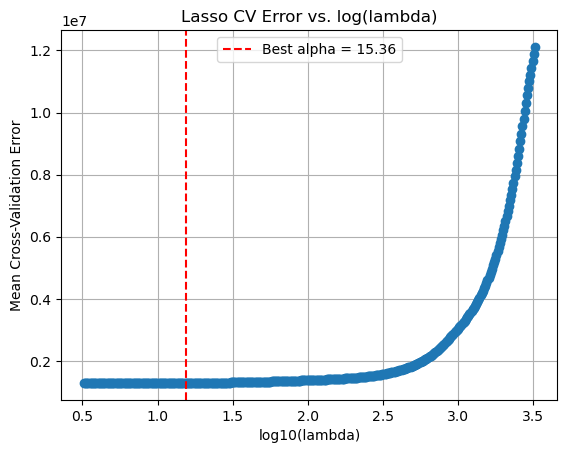

In [199]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso_cv', LassoCV(n_alphas=400, cv=5)),
])
pipeline.fit(X_train, y_train)

mse_path = pipeline.named_steps['lasso_cv'].mse_path_ # Get the MSE for each k-fold for each alpha
lambdas = pipeline.named_steps['lasso_cv'].alphas_ # .alpha returns best alpha, alaphs returns all alphas used
best_lambda = pipeline.named_steps['lasso_cv'].alpha_
mse_means = np.mean(mse_path, axis=1) # Need to get mean of all 5 folds for each alpha
print(f"Best Mean MSE = {np.min(mse_means)}")

plt.plot(np.log10(lambdas), mse_means, marker='o') # Make log scale plot
plt.axvline(np.log10(best_lambda), color='red', linestyle='--', label=f'Best alpha = {best_lambda:.2f}')
plt.xlabel('log10(lambda)')
plt.ylabel('Mean Cross-Validation Error')
plt.title('Lasso CV Error vs. log(lambda)')
plt.legend()
plt.grid(True)
plt.show()

In [197]:
coef_df = pd.DataFrame({'feature': X_test.columns, 'coefs': pipeline.named_steps['lasso_cv'].coef_})
coef_df

,feature,coefs
0,Private,-192.707629
1,Accept,2536.342517
2,Enroll,422.274785
3,Top10perc,976.658246
4,Top25perc,-300.253881
5,F.Undergrad,0.000000
6,P.Undergrad,2.068981
7,Outstate,-203.775841
8,Room.Board,239.325664
9,Books,-10.149574


- There are 15 non-zero coefficients

(e) Fit a PCR model on the training set, with M chosen by cross- validation. Report the test error obtained, along with the value of M selected by cross-validation.